In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv("Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Удалим бесполезные фичи
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [4]:
# Есть ли пропущенные значения в данных
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


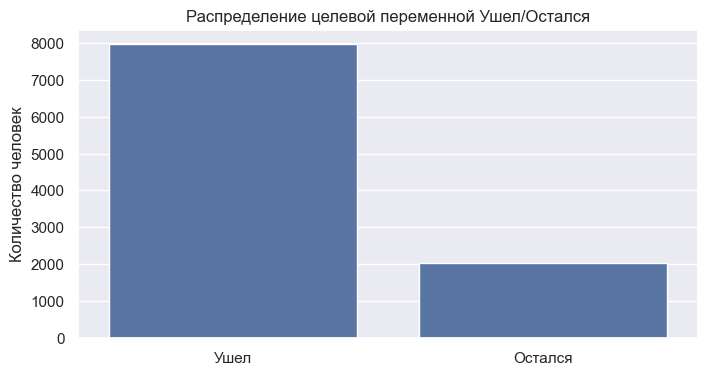

In [6]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Exited')
plt.title("Распределение целевой переменной Ушел/Остался")
plt.xticks(ticks=[0, 1], labels=['Ушел', 'Остался'])
plt.xlabel("")
plt.ylabel("Количество человек");

### Бинаризируем категориальные переменные (Geography, Gender)

In [7]:
categorial_features = df[['Geography', 'Gender']]
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
ohetransform = ohe.fit_transform(categorial_features)
ohetransform.head()

,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,1.0,0.0


In [8]:
df = df.drop(['Geography', 'Gender'], axis=1)
df = pd.concat([df, ohetransform], axis=1)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0,1.0,0.0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0,1.0,0.0
2,502,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0,1.0,0.0
3,699,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0,1.0,0.0
4,850,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0,1.0,0.0


In [9]:
X = df.drop('Exited', axis=1)
y = df.Exited

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Функция для метрик моделей
def get_model_metrics(y_pred):
    accuracy = accuracy_score(y_pred, y_test)
    precision = precision_score(y_pred, y_test)
    recall = recall_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    roc_auc = roc_auc_score(y_pred, y_test)

    print(f'Accuracy: {round(accuracy, 3)}')
    print(f'Precision: {round(precision, 3)}')
    print(f'Recall: {round(recall, 3)}')
    print(f'F1 score: {round(f1, 3)}')
    print(f'roc auc score: {round(roc_auc, 3)}')

### Логистическая регрессия без параметров

In [11]:
lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [12]:
lr_pred = lr.predict(X_test_scaled)

In [13]:
# Оценка показателей модели
get_model_metrics(lr_pred)

Accuracy: 0.697
Precision: 0.701
Recall: 0.397
F1 score: 0.507
roc auc score: 0.644


### Случайный лес без параметров

In [14]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [15]:
rf_pred = rf.predict(X_test_scaled)

In [16]:
# Оценка показателей модели
get_model_metrics(rf_pred)

Accuracy: 0.849
Precision: 0.461
Recall: 0.765
F1 score: 0.575
roc auc score: 0.813


### Случайный лес с поиском оптимальных параметров с помощью RandomizedSearchCV

In [17]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)

In [18]:
params = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 15),
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.5, 0.8]
}

In [19]:
random_search_model = RandomizedSearchCV(
    model, 
    params, 
    n_iter=100,
    cv=5, 
    n_jobs=-1,
    scoring='f1',
    random_state=42
)

In [20]:
best_model = random_search_model.fit(X_train_scaled, y_train)
best_model.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=11,
                       max_features='log2', min_samples_split=10,
                       n_estimators=300, random_state=42)

In [21]:
rs_pred = best_model.predict(X_test_scaled)

In [22]:
# Оценка показателей модели
get_model_metrics(rs_pred)

Accuracy: 0.837
Precision: 0.665
Recall: 0.624
F1 score: 0.644
roc auc score: 0.763
